# Time-Series MIA Example 

In [30]:
import os, sys, yaml, numpy as np, matplotlib.pyplot as plt, torch, pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)  # <--- Puts it at the front of the path

from examples.mia.time_series_mia.utils.data_preparation import preprocess_dataset, get_dataloaders
from examples.mia.time_series_mia.utils.metrics import mse, smape, mae, nd
from examples.mia.time_series_mia.utils.model_preparation import create_trained_model_and_metadata, predict
from examples.mia.time_series_mia.utils.models.LSTM import LSTM
from examples.mia.time_series_mia.utils.models.TCN import TCN
from examples.mia.time_series_mia.utils.models.DLinear import DLinear
from examples.mia.time_series_mia.utils.models.NBeats import NBeats
from examples.mia.time_series_mia.utils.models.WaveNet import WaveNet
from examples.mia.time_series_mia.utils.models.Bromick import Bromick
from examples.mia.time_series_mia.utils.models.NHiTS import NHiTS
from examples.mia.time_series_mia.utils.set_seed import set_seed

from data_handler import IndividualizedInputHandler
from leakpro import LeakPro

In [31]:
audit_config_path = "audit.yaml"
train_config_path = "train_config.yaml"

# Load the yaml files
with open(audit_config_path, 'r') as file:
    audit_config = yaml.safe_load(file)

with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)

In [32]:
random_seed = train_config["run"]["random_seed"]
log_dir = train_config["run"]["log_dir"]

epochs = train_config["train"]["epochs"]
batch_size = train_config["train"]["batch_size"]
optimizer = train_config["train"]["optimizer"]
loss_fn = train_config["train"]["loss"]

lookback = train_config["data"]["lookback"]
horizon = train_config["data"]["horizon"]
num_individuals = train_config["data"]["num_individuals"]
train_fraction = train_config["data"]["f_train"]
val_fraction = train_config["data"].get("f_val", 0.0)
test_fraction = train_config["data"]["f_test"]
dataset_name = train_config["data"]["dataset"]
data_dir = train_config["data"]["data_dir"]
stride = train_config["data"]["stride"]
k_lead = train_config["data"]["k_lead"] # number of leading variables to use
num_time_steps = train_config["data"]["num_time_steps"] # number of time steps per individual
scaling = train_config["data"].get("scaling", "none") # none, standard, minmax, or robust

early_stopping = train_config["train"].get("early_stopping", False)
patience = train_config["train"].get("patience", 2)

if early_stopping and round(val_fraction * num_individuals) < 1:
    raise Exception("Early stopping applied but validation set is empty.")

In [33]:
# Get data loaders
path = os.path.join(os.getcwd(), data_dir)
target_data_path = audit_config["target"]["data_path"]
target_data_file = os.path.basename(target_data_path) # Only look at file name of target data path
target_data_file = os.path.splitext(target_data_file)[0]

if target_data_file != dataset_name:
    raise Exception(f"Received unknown dataset or mismatching target file: dataset={dataset_name}, target={target_data_path}.")

set_seed(random_seed) # Set seed before and after, to ensure same randomness if you process or dont process dataset (dataset already processed)
dataset = preprocess_dataset(dataset_name, path, lookback, horizon, num_individuals, stride, scaling, val_fraction, k_lead=k_lead, num_time_steps=num_time_steps)

set_seed(random_seed)
train_loader, val_loader, test_loader = get_dataloaders(dataset, train_fraction, test_fraction, batch_size=batch_size)

In [34]:
individual_length = dataset.individual_indices[0][1] - dataset.individual_indices[0][0]
num_train_individuals = len(train_loader.dataset) // individual_length
num_test_individuals = len(test_loader.dataset) // individual_length
print(f"Total {num_individuals} individuals whereof {num_train_individuals} train, {dataset.num_val_individuals} val, and {num_test_individuals} test")

Total 300 individuals whereof 60 train, 60 val, and 60 test


In [35]:
# Train the model
input_dim = dataset.input_dim
model_name = audit_config["target"]["model_class"]

if model_name == "LSTM":
    model = LSTM(input_dim, horizon)
elif model_name == "TCN":
    model = TCN(input_dim, horizon)
elif model_name == "DLinear":
    model = DLinear(input_dim, lookback, horizon)
elif model_name == "NBeats":
    model = NBeats(input_dim, lookback, horizon)
elif model_name == "WaveNet":
    model = WaveNet(input_dim, horizon)
elif model_name == "NHiTS":
    model = NHiTS(input_dim, lookback, horizon)
elif model_name == "Bromick" or model_name == "Bhowmick":
    model = Bromick(input_dim, horizon)
else:
    raise NotImplementedError()

train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs, optimizer, loss_fn, dataset_name, val_loader, early_stopping, patience)

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training Progress:  10%|█         | 5/50 [01:17<11:39, 15.54s/it]

Training stopped early at epoch 6.
Best weights restored.


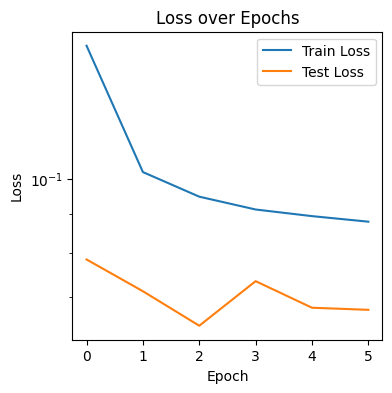

In [36]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

### Plot metrics for final target model

In [39]:
# Print metrics on final model, unscaled vs scaled, train and test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = dataset.scaler

train = predict(model, train_loader, device, scaler, original_scale=False)
test  = predict(model, test_loader, device, scaler, original_scale=False)
unscaled_train = predict(model, train_loader, device, scaler, original_scale=True)
unscaled_test  = predict(model, test_loader, device, scaler, original_scale=True)

metrics, names = [mse, mae, smape, nd], ["MSE", "MAE", "SMAPE", "ND"]

if val_loader:
    val  = predict(model, val_loader, device, scaler, original_scale=False)
    unscaled_val = predict(model, val_loader, device, scaler, original_scale=True)
    values = [[m(*p) for m in metrics] for p in [train, test, val, unscaled_train, unscaled_test, unscaled_val]]
    print(pd.DataFrame(values, columns=names, index=["Train", "Test", "Val", "Unscaled train", "Unscaled test", "Unscaled val"]))
else:
    values = [[m(*p) for m in metrics] for p in [train, test, unscaled_train, unscaled_test]]
    print(pd.DataFrame(values, columns=names, index=["Train", "Test", "Unscaled train", "Unscaled test"]))


                          MSE         MAE     SMAPE        ND
Train                0.078605    0.094264  0.120025  0.094174
Test                 0.023624    0.067469  0.110148  0.094734
Val                  0.239899    0.127383  0.133478  0.079499
Unscaled train   95375.742188  103.833664  0.067280  0.074381
Unscaled test    28663.712891   74.318848  0.078345  0.072760
Unscaled val    291083.031250  140.315109  0.069960  0.068052


### Plotting sample predictions

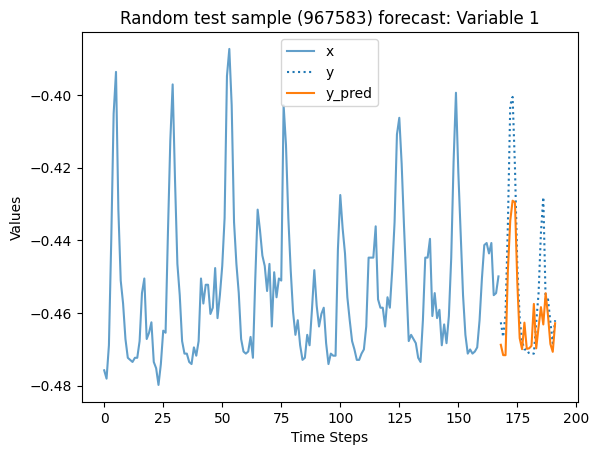

In [38]:
# Get random sample (re-execute for new one)
indices = test_loader.dataset.indices
random_sample_idx = np.random.choice(indices)
x = dataset.x[random_sample_idx,:,:].to(device)
y = dataset.y[random_sample_idx,:,:]
y_pred = model(x.unsqueeze(0)).detach().squeeze(0)

# Time axis
time_x = np.arange(lookback)
time_y = np.arange(lookback, lookback + horizon)

for i in range(y.shape[-1]):  # plot forecast for each variable in the series
    plt.plot(time_x, x[:, i].cpu().numpy(), label='x', alpha=0.7)  # lookback
    plt.plot(time_y, y[:, i], label='y', color='C0', linestyle='dotted')  # true horizon
    plt.plot(time_y, y_pred[:, i].cpu().numpy(), label='y_pred', color='C1')  # prediction

    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.title(f"Random test sample ({random_sample_idx}) forecast: Variable {i+1}")
    plt.show()

### Running MIA

In [10]:
# Prepare leakpro object
leakpro = LeakPro(IndividualizedInputHandler, audit_config_path)

# Run the audit 
mia_results = leakpro.run_audit(return_results=True)

2025-04-02 12:49:48,093 INFO     Target model blueprint created from NHiTS in ./utils/models/NHiTS.py.
2025-04-02 12:49:48,415 INFO     Loaded target model metadata from ./target/model_metadata.pkl
2025-04-02 12:49:48,445 INFO     Loaded target model from ./target
2025-04-02 12:49:50,568 INFO     Loaded population dataset from ../../../../data/ELD.pkl
2025-04-02 12:49:50,568 INFO     Loaded population dataset from ../../../../data/ELD.pkl
2025-04-02 12:49:50,725 INFO     MIA attack factory loaded.
2025-04-02 12:49:50,726 INFO     Creating shadow model handler singleton
2025-04-02 12:49:50,727 INFO     Created folder ./leakpro_output/attack_objects/shadow_model
2025-04-02 12:49:50,740 INFO     Creating distillation model handler singleton
2025-04-02 12:49:50,741 INFO     Created folder ./leakpro_output/attack_objects/distillation_model
2025-04-02 12:49:50,753 INFO     Configuring the RMIA attack
2025-04-02 12:49:50,786 INFO     User provided value for gamma, it won't be optimized by opt

Training stopped early at epoch 10.
Best weights restored.



2025-04-02 12:52:20,041 INFO     Training shadow model 0 complete
2025-04-02 12:52:20,048 INFO     Saved shadow model 0 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 12:52:20,048 INFO     Storing metadata for shadow model 0
2025-04-02 12:52:20,049 INFO     Metadata for shadow model 0:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([1234375,   89628,  162479, ...,   88680,  150383,  258612]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 315632994.0625, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 12:52:20,276 INFO     Metadata for shadow model 0 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 12:52:20,630 INFO     Training shadow model 1 on 627712 points
Training Progress:  22%|██▏       | 11/50 [02:44<

Training stopped early at epoch 12.
Best weights restored.



2025-04-02 12:55:05,794 INFO     Training shadow model 1 complete
2025-04-02 12:55:05,801 INFO     Saved shadow model 1 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 12:55:05,802 INFO     Storing metadata for shadow model 1
2025-04-02 12:55:05,803 INFO     Metadata for shadow model 1:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([   8267,  683740,  335716, ..., 1138639,   98352,  586267]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 301237421.5625, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 12:55:06,044 INFO     Metadata for shadow model 1 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 12:55:06,381 INFO     Training shadow model 2 on 627712 points
Training Progress:  18%|█▊        | 9/50 [02:17<1

Training stopped early at epoch 10.
Best weights restored.



2025-04-02 12:57:24,160 INFO     Training shadow model 2 complete
2025-04-02 12:57:24,167 INFO     Saved shadow model 2 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 12:57:24,167 INFO     Storing metadata for shadow model 2
2025-04-02 12:57:24,168 INFO     Metadata for shadow model 2:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([ 507539, 1210663,  107097, ..., 1247397,  121293,  569058]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 327424097.40625, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 12:57:24,407 INFO     Metadata for shadow model 2 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 12:57:24,743 INFO     Training shadow model 3 on 627712 points
Training Progress:  30%|███       | 15/50 [03:39

Training stopped early at epoch 16.
Best weights restored.



2025-04-02 13:01:04,775 INFO     Training shadow model 3 complete
2025-04-02 13:01:04,782 INFO     Saved shadow model 3 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:01:04,782 INFO     Storing metadata for shadow model 3
2025-04-02 13:01:04,783 INFO     Metadata for shadow model 3:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([ 148354,  177946,  123971, ..., 1087775,  216119, 1038436]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 274615503.7890625, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:01:05,026 INFO     Metadata for shadow model 3 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:01:05,360 INFO     Training shadow model 4 on 627712 points
Training Progress:  16%|█▌        | 8/50 [02:0

Training stopped early at epoch 9.
Best weights restored.



2025-04-02 13:03:09,163 INFO     Training shadow model 4 complete
2025-04-02 13:03:09,170 INFO     Saved shadow model 4 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:03:09,170 INFO     Storing metadata for shadow model 4
2025-04-02 13:03:09,171 INFO     Metadata for shadow model 4:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([301208, 719980, 236260, ..., 401485, 155442, 534789]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 321105231.109375, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:03:09,414 INFO     Metadata for shadow model 4 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:03:09,759 INFO     Training shadow model 5 on 627712 points
Training Progress:  14%|█▍        | 7/50 [01:49<11:15

Training stopped early at epoch 8.
Best weights restored.



2025-04-02 13:05:00,264 INFO     Training shadow model 5 complete
2025-04-02 13:05:00,272 INFO     Saved shadow model 5 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:05:00,273 INFO     Storing metadata for shadow model 5
2025-04-02 13:05:00,274 INFO     Metadata for shadow model 5:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([ 309187,  444618,  601728, ...,  221751, 1026923,  947669]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 88293132.609375, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:05:00,516 INFO     Metadata for shadow model 5 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:05:00,852 INFO     Training shadow model 6 on 627712 points
Training Progress:  24%|██▍       | 12/50 [02:59

Training stopped early at epoch 13.
Best weights restored.



2025-04-02 13:08:01,250 INFO     Training shadow model 6 complete
2025-04-02 13:08:01,256 INFO     Saved shadow model 6 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:08:01,257 INFO     Storing metadata for shadow model 6
2025-04-02 13:08:01,258 INFO     Metadata for shadow model 6:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([ 800873,  893896, 1057128, ..., 1240166,  463153,  673891]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 18078009.26171875, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:08:01,502 INFO     Metadata for shadow model 6 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:08:01,859 INFO     Training shadow model 7 on 627712 points
Training Progress:  34%|███▍      | 17/50 [04:

Training stopped early at epoch 18.
Best weights restored.



2025-04-02 13:12:10,726 INFO     Training shadow model 7 complete
2025-04-02 13:12:10,733 INFO     Saved shadow model 7 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:12:10,733 INFO     Storing metadata for shadow model 7
2025-04-02 13:12:10,734 INFO     Metadata for shadow model 7:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([1005448,  200950,  588909, ...,   71372,  994009,  917753]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 239473602.2578125, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:12:10,978 INFO     Metadata for shadow model 7 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:12:11,318 INFO     Training shadow model 8 on 627712 points
Training Progress:  22%|██▏       | 11/50 [02:

Training stopped early at epoch 12.
Best weights restored.



2025-04-02 13:14:59,160 INFO     Training shadow model 8 complete
2025-04-02 13:14:59,167 INFO     Saved shadow model 8 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:14:59,167 INFO     Storing metadata for shadow model 8
2025-04-02 13:14:59,169 INFO     Metadata for shadow model 8:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([217277, 838396, 795041, ...,   5054, 939993, 771469]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 309299867.0078125, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:14:59,414 INFO     Metadata for shadow model 8 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:14:59,783 INFO     Training shadow model 9 on 627712 points
Training Progress:  30%|███       | 15/50 [03:49<08:

Training stopped early at epoch 16.
Best weights restored.



2025-04-02 13:18:50,444 INFO     Training shadow model 9 complete
2025-04-02 13:18:50,453 INFO     Saved shadow model 9 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:18:50,453 INFO     Storing metadata for shadow model 9
2025-04-02 13:18:50,454 INFO     Metadata for shadow model 9:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([1162643,  843530, 1002340, ...,  170277,  892989,   60145]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 270545984.859375, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:18:50,720 INFO     Metadata for shadow model 9 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:18:51,135 INFO     Training shadow model 10 on 627712 points
Training Progress:  18%|█▊        | 9/50 [02:2

Training stopped early at epoch 10.
Best weights restored.



2025-04-02 13:21:19,225 INFO     Training shadow model 10 complete
2025-04-02 13:21:19,234 INFO     Saved shadow model 10 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:21:19,235 INFO     Storing metadata for shadow model 10
2025-04-02 13:21:19,237 INFO     Metadata for shadow model 10:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([  12258,  608246,  754785, ..., 1036428,  294828, 1055512]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 335331106.71875, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:21:19,509 INFO     Metadata for shadow model 10 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:21:19,893 INFO     Training shadow model 11 on 627712 points
Training Progress:  14%|█▍        | 7/50 [

Training stopped early at epoch 8.
Best weights restored.



2025-04-02 13:23:24,771 INFO     Training shadow model 11 complete
2025-04-02 13:23:24,778 INFO     Saved shadow model 11 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:23:24,779 INFO     Storing metadata for shadow model 11
2025-04-02 13:23:24,780 INFO     Metadata for shadow model 11:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([ 310260, 1216414, 1211986, ...,  897655,  434304,  743588]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 364043198.21875, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:23:25,027 INFO     Metadata for shadow model 11 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:23:25,380 INFO     Training shadow model 12 on 627712 points
Training Progress:  20%|██        | 10/50 

Training stopped early at epoch 11.
Best weights restored.



2025-04-02 13:26:06,848 INFO     Training shadow model 12 complete
2025-04-02 13:26:06,856 INFO     Saved shadow model 12 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:26:06,856 INFO     Storing metadata for shadow model 12
2025-04-02 13:26:06,857 INFO     Metadata for shadow model 12:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([1042083, 1060206, 1055516, ...,  130606,  151457,  607151]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 291723376.69921875, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:26:07,106 INFO     Metadata for shadow model 12 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:26:07,482 INFO     Training shadow model 13 on 627712 points
Training Progress:  24%|██▍       | 12/

Training stopped early at epoch 13.
Best weights restored.



2025-04-02 13:29:23,385 INFO     Training shadow model 13 complete
2025-04-02 13:29:23,394 INFO     Saved shadow model 13 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:29:23,395 INFO     Storing metadata for shadow model 13
2025-04-02 13:29:23,396 INFO     Metadata for shadow model 13:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([ 933850,  797771, 1221067, ...,  491210,  363870,  283095]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 273297319.3935547, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:29:23,661 INFO     Metadata for shadow model 13 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:29:24,020 INFO     Training shadow model 14 on 627712 points
Training Progress:  26%|██▌       | 13/5

Training stopped early at epoch 14.
Best weights restored.



2025-04-02 13:32:46,529 INFO     Training shadow model 14 complete
2025-04-02 13:32:46,538 INFO     Saved shadow model 14 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:32:46,539 INFO     Storing metadata for shadow model 14
2025-04-02 13:32:46,540 INFO     Metadata for shadow model 14:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([ 857832,  994930, 1240415, ..., 1125000,  687207,  486777]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 283847614.3574219, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:32:46,808 INFO     Metadata for shadow model 14 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:32:47,199 INFO     Training shadow model 15 on 627712 points
Training Progress:  18%|█▊        | 9/50

Training stopped early at epoch 10.
Best weights restored.



2025-04-02 13:35:13,141 INFO     Training shadow model 15 complete
2025-04-02 13:35:13,149 INFO     Saved shadow model 15 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:35:13,150 INFO     Storing metadata for shadow model 15
2025-04-02 13:35:13,150 INFO     Metadata for shadow model 15:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([1139778,  863723,  164397, ...,   24804,  879552,  220193]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 326216059.96484375, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:35:13,415 INFO     Metadata for shadow model 15 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:35:13,787 INFO     Training shadow model 16 on 627712 points
Training Progress:  30%|███       | 15/

Training stopped early at epoch 16.
Best weights restored.



2025-04-02 13:39:06,291 INFO     Training shadow model 16 complete
2025-04-02 13:39:06,298 INFO     Saved shadow model 16 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:39:06,299 INFO     Storing metadata for shadow model 16
2025-04-02 13:39:06,300 INFO     Metadata for shadow model 16:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([ 558007,  308115,  200059, ..., 1175252,  880374,  599722]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 274527426.3515625, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:39:06,546 INFO     Metadata for shadow model 16 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:39:06,907 INFO     Training shadow model 17 on 627712 points
Training Progress:  16%|█▌        | 8/50

Training stopped early at epoch 9.
Best weights restored.



2025-04-02 13:41:15,269 INFO     Training shadow model 17 complete
2025-04-02 13:41:15,277 INFO     Saved shadow model 17 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:41:15,278 INFO     Storing metadata for shadow model 17
2025-04-02 13:41:15,279 INFO     Metadata for shadow model 17:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([372927, 252029, 918397, ..., 142568,  73310, 916101]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 55071079.734375, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:41:15,544 INFO     Metadata for shadow model 17 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:41:15,899 INFO     Training shadow model 18 on 627712 points
Training Progress:  20%|██        | 10/50 [02:43

Training stopped early at epoch 11.
Best weights restored.



2025-04-02 13:43:59,653 INFO     Training shadow model 18 complete
2025-04-02 13:43:59,660 INFO     Saved shadow model 18 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:43:59,661 INFO     Storing metadata for shadow model 18
2025-04-02 13:43:59,662 INFO     Metadata for shadow model 18:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([ 926756, 1010841, 1225949, ..., 1012534,  823773,  710538]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 330730272.96875, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:43:59,910 INFO     Metadata for shadow model 18 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:44:00,260 INFO     Training shadow model 19 on 627712 points
Training Progress:  28%|██▊       | 14/50 

Training stopped early at epoch 15.
Best weights restored.



2025-04-02 13:47:46,072 INFO     Training shadow model 19 complete
2025-04-02 13:47:46,080 INFO     Saved shadow model 19 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:47:46,081 INFO     Storing metadata for shadow model 19
2025-04-02 13:47:46,082 INFO     Metadata for shadow model 19:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([ 421000,  274717,  957525, ...,  683909, 1032423,  541590]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 275377627.125, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:47:46,351 INFO     Metadata for shadow model 19 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:47:46,760 INFO     Training shadow model 20 on 627712 points
Training Progress:  22%|██▏       | 11/50 [0

Training stopped early at epoch 12.
Best weights restored.



2025-04-02 13:50:35,926 INFO     Training shadow model 20 complete
2025-04-02 13:50:35,933 INFO     Saved shadow model 20 to ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:50:35,934 INFO     Storing metadata for shadow model 20
2025-04-02 13:50:35,934 INFO     Metadata for shadow model 20:
{'init_params': {'input_dim': 1, 'lookback': 168, 'horizon': 24}, 'train_indices': array([1091329,   46360,  904289, ...,  657406, 1195730,  639063]), 'num_train': 626760, 'optimizer': 'Adam', 'criterion': 'MSELoss', 'batch_size': 1024, 'epochs': 50, 'train_acc': 0, 'train_loss': 60977593.390625, 'test_acc': 0.0, 'test_loss': 0.0, 'online': True, 'model_class': 'NHiTS', 'target_model_hash': '1d549478a34f98a5c563edf5bf710d2004acc0b96183b3acbf1d2bf63ac94721'}
2025-04-02 13:50:36,178 INFO     Metadata for shadow model 20 stored in ./leakpro_output/attack_objects/shadow_model
2025-04-02 13:50:36,510 INFO     Training shadow model 21 on 627712 points
Training Progress:   0%|          | 0/50 [

KeyboardInterrupt: 

### Generate report

In [ ]:
# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

# Create the report by compiling the latex text
report_handler.create_report()

2025-03-21 10:43:53,886 INFO     Initializing report handler...
2025-03-21 10:43:53,887 INFO     report_dir set to: ./leakpro_output/results
2025-03-21 10:43:53,887 INFO     Saving results for lira


2025-03-21 10:44:20,032 INFO     No results of type GIAResults found.
2025-03-21 10:44:20,033 INFO     No results of type SinglingOutResults found.
2025-03-21 10:44:20,033 INFO     No results of type InferenceResults found.
2025-03-21 10:44:20,034 INFO     No results of type LinkabilityResults found.
2025-03-21 10:44:26,095 INFO     PDF compiled


<Figure size 640x480 with 0 Axes>